# Predicting the onset of the communal conflict in the comming 12 months at admin2 level in Ethiopia
#### Y= cc_onset
#### X= 'fatalities', 'actor_state', 'actor_rebel_groups', 'actor_political_militias', 'actor_identity_militias', 'actor_civilians', 'actor_others', 'cc_onset', 'inflation_all', 'rainfall', 'rainfall_lag', 'temperature mean', 'btotl', 'maize_ETB_KG', 'teff_ETB_KG', 'wheat_ETB_KG', 'mean ndvi', 'fs_Crisis', 'fs_Emergency', 'fs_Famine', 'fs_Minimal', 'fs_Stressed'

#### Group variables: admin1, admin2, year, month

#### Functional form stracture objective Yt=X(t-1)+...+X(t-12)

#### where t is a month

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["No conflict","Conflict"]

In [35]:
#url = 'https://data.kimetrica.com/dataset/4dbc3cc7-9474-49f2-bfd4-231e78401caa/resource/7423b71d-ce8c-437c-9fe6-2d9ba58d6155/download/dataset_communal_cnflict_model.csv'
df = pd.read_csv('/Users/yaredhurisa/Google Drive/Probability of conflict/indicators/eth_cc_final_dataset_monthly.csv')
list(df.columns)

['Unnamed: 0',
 'group',
 'date',
 'cc_onset',
 'fatalities',
 'cc_onset_1',
 'fatalities_1',
 'actor_state_1',
 'actor_rebel_groups_1',
 'actor_political_militias_1',
 'actor_identity_militias_1',
 'actor_civilians_1',
 'actor_others_1',
 'inflation_all_1',
 'rainfall_1',
 'temperature_1',
 'pop_1',
 'maize_kg_birr_1',
 'teff_kg_birr_1',
 'wheat_kg_birr_1',
 'ndvi_1',
 'fs_crisis_1',
 'df_emergency_1',
 'fs_famine_1',
 'fs_minimal_1',
 'fs_stressed_1',
 'cc_onset_2',
 'fatalities_2',
 'actor_state_2',
 'actor_rebel_groups_2',
 'actor_political_militias_2',
 'actor_identity_militias_2',
 'actor_civilians_2',
 'actor_others_2',
 'inflation_all_2',
 'rainfall_2',
 'temperature_2',
 'pop_2',
 'maize_kg_birr_2',
 'teff_kg_birr_2',
 'wheat_kg_birr_2',
 'ndvi_2',
 'fs_crisis_2',
 'df_emergency_2',
 'fs_famine_2',
 'fs_minimal_2',
 'fs_stressed_2',
 'cc_onset_3',
 'fatalities_3',
 'actor_state_3',
 'actor_rebel_groups_3',
 'actor_political_militias_3',
 'actor_identity_militias_3',
 'actor_ci

In [36]:
#Training, and test 
start_date = "2009-12-01"
end_date = "2018-01-01"
mask = (df['date'] > start_date) & (df['date'] < end_date)
train1 = df.loc[mask]


start_date = "2017-12-01"
end_date = "2019-01-01"
mask = (df['date'] > start_date) & (df['date'] < end_date)
test1 = df.loc[mask]



In [37]:
# Remove time column, and the categorical columns
train = train1.drop(['Unnamed: 0','date', 'group'], axis=1)
test = test1.drop(['Unnamed: 0','date', 'group'], axis=1)
#train = train1.drop(['Unnamed: 0','date', 'group', 'fatalities_1','fatalities_2','fatalities_3','fatalities_4','fatalities_5','fatalities_6','fatalities_7','fatalities_8','fatalities_9','fatalities_10','fatalities_11', 'fatalities_12',], axis=1)
#test = test1.drop(['Unnamed: 0','date', 'group', 'fatalities_1','fatalities_2','fatalities_3','fatalities_4','fatalities_5','fatalities_6','fatalities_7','fatalities_8','fatalities_9','fatalities_10','fatalities_11', 'fatalities_12',], axis=1)

In [38]:
train.shape

(7104, 254)

In [39]:
df_train_0 = train.loc[train['cc_onset'] == 0]
df_train_1 = train.loc[train['cc_onset'] == 1]
df_train_0_x = df_train_0.drop(['cc_onset'], axis=1)
df_train_1_x = df_train_1.drop(['cc_onset'], axis=1)

df_test_0 = test.loc[test['cc_onset'] == 0]
df_test_1 = test.loc[test['cc_onset'] == 1]
df_test_0_x = df_test_0.drop(['cc_onset'], axis=1)
df_test_1_x = df_test_1.drop(['cc_onset'], axis=1)

In [40]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(test.drop(['cc_onset'], axis = 1))

In [41]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 253)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                8128      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_15 (Dense)             (None, 253)               8349      
Total params: 17,821
Trainable params: 17,821
Non-trainable params: 0
_______________________________________________________

In [43]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_test_x_rescaled, df_test_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 7006 samples, validate on 888 samples
Epoch 1/200
7006/7006 [==============================] - 0s 51us/step - loss: 1.9854 - accuracy: 0.0064 - val_loss: 5.4120 - val_accuracy: 0.0045
Epoch 2/200
7006/7006 [==============================] - 0s 21us/step - loss: 1.4464 - accuracy: 0.0066 - val_loss: 4.7298 - val_accuracy: 0.0034
Epoch 3/200
7006/7006 [==============================] - 0s 21us/step - loss: 1.2113 - accuracy: 0.0097 - val_loss: 4.2112 - val_accuracy: 0.0045
Epoch 4/200
7006/7006 [==============================] - 0s 20us/step - loss: 1.0698 - accuracy: 0.0131 - val_loss: 3.8572 - val_accuracy: 0.0034
Epoch 5/200
7006/7006 [==============================] - 0s 20us/step - loss: 0.9902 - accuracy: 0.0176 - val_loss: 3.6807 - val_accuracy: 0.0011
Epoch 6/200
7006/7006 [==============================] - 0s 19us/step - loss: 0.9317 - accuracy: 0.0126 - val_loss: 3.5403 - val_accuracy: 0.0034
Epoch 7/200
7006/7006 [==============================] - 0s 19us/step - loss:

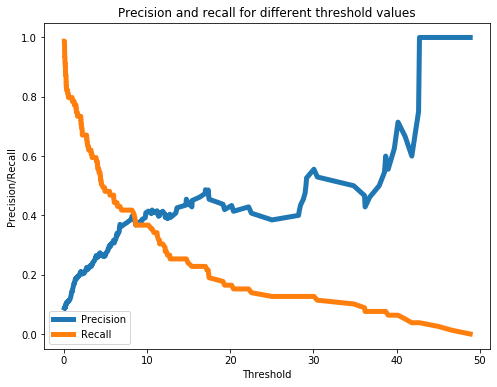

In [42]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test['cc_onset']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

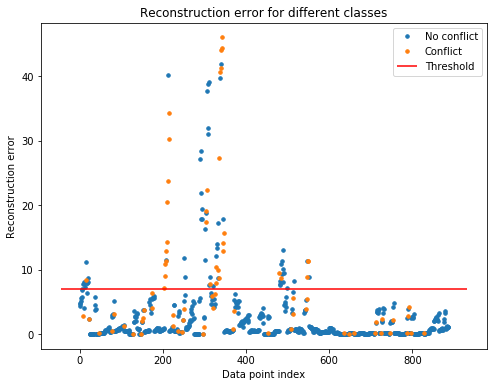

In [67]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test['cc_onset']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 7
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Conflict" if name == 1 else "No conflict")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

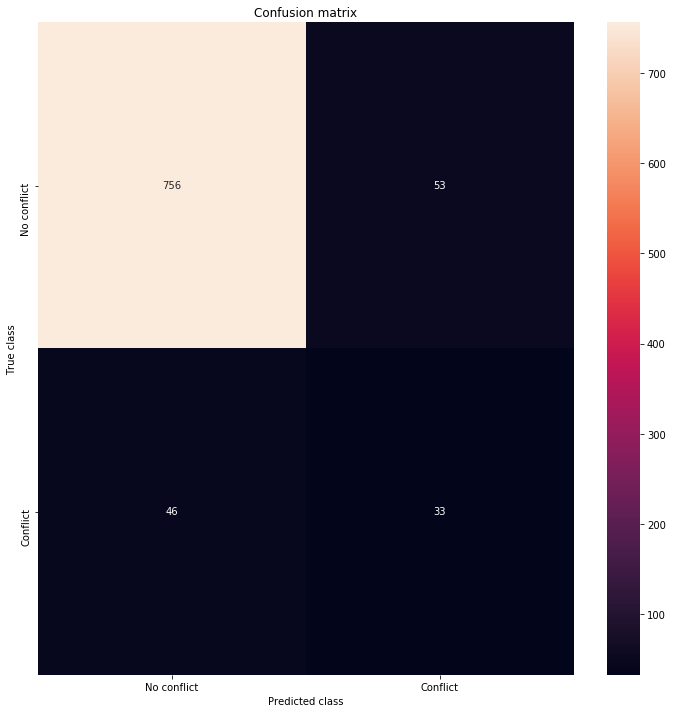

In [68]:
pred_y_test = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y_test)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('communal_conflict_prediction_performance')
plt.show()

In [69]:
test_cc=test.cc_onset
pred_y_test=pd.DataFrame(pred_y_test)
print(classification_report(test_cc, pred_y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       809
         1.0       0.38      0.42      0.40        79

    accuracy                           0.89       888
   macro avg       0.66      0.68      0.67       888
weighted avg       0.89      0.89      0.89       888



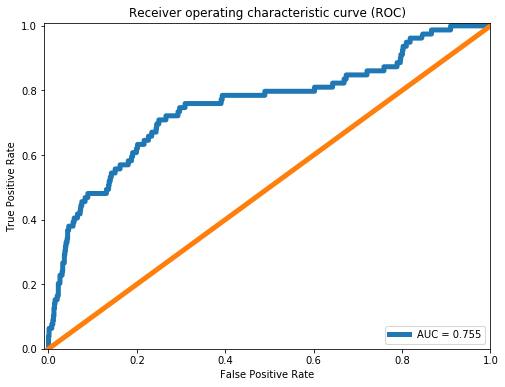

In [70]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
error_df_test


,index,Reconstruction_error,True_class
0,20,4.344605,0.0
1,43,4.691387,0.0
2,66,4.856397,0.0
3,89,5.073983,0.0
4,112,5.630373,0.0
5,135,6.893424,0.0
6,158,5.702304,0.0
7,181,6.993790,0.0
8,204,2.785631,1.0
9,227,7.710568,0.0


In [72]:
test2=test1[['group','cc_onset']]
test2=test2.reset_index()

In [73]:
actual_pred=pd.merge(test2, error_df_test, how='left', on=['index'])

In [51]:
actual_pred.shape

(888, 5)

In [52]:
actual_pred

,index,group,cc_onset,Reconstruction_error,True_class
0,20,Addis Ababa_Addis Ababa,0.0,4.344605,0.0
1,43,Addis Ababa_Addis Ababa,0.0,4.691387,0.0
2,66,Addis Ababa_Addis Ababa,0.0,4.856397,0.0
3,89,Addis Ababa_Addis Ababa,0.0,5.073983,0.0
4,112,Addis Ababa_Addis Ababa,0.0,5.630373,0.0
5,135,Addis Ababa_Addis Ababa,0.0,6.893424,0.0
6,158,Addis Ababa_Addis Ababa,0.0,5.702304,0.0
7,181,Addis Ababa_Addis Ababa,0.0,6.993790,0.0
8,204,Addis Ababa_Addis Ababa,1.0,2.785631,1.0
9,227,Addis Ababa_Addis Ababa,0.0,7.710568,0.0


In [53]:
actual_pred['pred_y_test'] = [1 if e > 7 else 0 for e in actual_pred.Reconstruction_error.values]


In [54]:
actual_pred

,index,group,cc_onset,Reconstruction_error,True_class,pred_y_test
0,20,Addis Ababa_Addis Ababa,0.0,4.344605,0.0,0
1,43,Addis Ababa_Addis Ababa,0.0,4.691387,0.0,0
2,66,Addis Ababa_Addis Ababa,0.0,4.856397,0.0,0
3,89,Addis Ababa_Addis Ababa,0.0,5.073983,0.0,0
4,112,Addis Ababa_Addis Ababa,0.0,5.630373,0.0,0
5,135,Addis Ababa_Addis Ababa,0.0,6.893424,0.0,0
6,158,Addis Ababa_Addis Ababa,0.0,5.702304,0.0,0
7,181,Addis Ababa_Addis Ababa,0.0,6.993790,0.0,0
8,204,Addis Ababa_Addis Ababa,1.0,2.785631,1.0,0
9,227,Addis Ababa_Addis Ababa,0.0,7.710568,0.0,1


In [55]:
print(classification_report(actual_pred.cc_onset, actual_pred.pred_y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       809
         1.0       0.38      0.42      0.40        79

    accuracy                           0.89       888
   macro avg       0.66      0.68      0.67       888
weighted avg       0.89      0.89      0.89       888



In [56]:
actual_pred.to_csv('/Users/yaredhurisa/Google Drive/Probability of conflict/indicators/eth_cc_forecast_12_month.csv')